## What to expect as an Airbnb Host in Berlin

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

In Germany, no city is more popular than Berlin. That implies that Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

Considering the possibility that I might have to relocate for a new data science job, but want to keep my current flat in Berlin (which is quite cheap!), I might wonder if it could be worth it to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, it is difficult for potential hosts to know what the true value of their home is, and how in-demand their home might be. And since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The following three questions will drive this project:

> **1. Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>
> **2. How big is the demand likely to be? What can a host expect with respect to occupancy and earnings here in Berlin? What factors influence how in-demand it is?** <br>
> **3. And lastly: What do visitors like and dislike?**

The **first question** focuses on the accommodation features and decisions a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. The **second
question** is similar and even stronger. It focuses on geography to explain the demand, but will mainly use visualizations to narrow down the search for answers. The **last question** processes the reviews to find out what peoples' likes and dislikes are. Natural Language Processing (NLP) and specifically Sentiment Analysis are what we will use here.

To not prevent my notebook(s) from ever being read due to their length, I wrote one "paper" - aka notebook - for each question. The first notebook can be found here (**Insert Link!!!!**) and the second one here (**Insert Link!!!!**).

### The datasets

In the third and last notebook, I will use the reviews data and combine it with some features from the detailed Berlin listings data, sourced from the Inside Airbnb website. Both datasets were scraped on November 07th 2018. Hopefully we will find out the visitors' wants and needs.

## > No. 3 _ Understanding Visitors' Wants and Needs
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Dealing with Missing Values'> 2.1. Dealing with Missing Values </a>
* <a href='#2.2. Language Detection'> 2.2. Language Detection </a>

### <a href='#3. Visualizing the Data with WordClouds'> 3. Visualizing the Data with WordClouds </a>

### <a href='#4. Sentiment Analysis'> 4. Sentiment Analysis </a>
* <a href='#4.1. Get used to VADER package'> 4.1. Get used to VADER package </a>
* <a href='#4.2. Calculating Sentiment Scores'> 4.2. Calculating Sentiment Scores </a>
* <a href='#4.3. Comparing Negative and Positive Comments'> 4.3. Comparing Negative and Positive Comments </a>
* <a href='#4.4. Investigating Positive Comments'> 4.4. Investigating Positive Comments </a>
* <a href='#4.5. Investigating Negative Comments'> 4.5. Investigating Negative Comments </a>

### <a href='#5. Interpreting the Data'> 5. Interpreting the Data </a>

### <a href='#6. Appendix'> 6. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

In [2]:
df_1 = pd.read_csv('data/insideAirbnb/reviews.csv.gz')

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 401963 rows and 6 columns.
It contains 0 duplicates.


In [3]:
df_1.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


Well, it may be valuable to have some more details such as the latitude and longitude of the accommodation that has been reviewed, or the host id, and the neighbourhood etc. 

To get this information, let's **combine our reviews_dataframe** with the **listings_dataframe** and take only the columns in need from the latter one:

In [4]:
df_2 = pd.read_csv('data/insideAirbnb/listings.csv.gz')

# merging my full df_1 + add only the cleaning fee in df_2
df = pd.merge(df_1, df_2[['neighbourhood_group_cleansed', 'host_id', 'latitude',
                          'longitude', 'number_of_reviews', 'id', 'property_type']], 
              left_on='listing_id', right_on='id', how='left')

df.rename(columns = {'id_x':'id', 'neighbourhood_group_cleansed':'neighbourhood_group'}, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [5]:
df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...,Mitte,2217,52.534537,13.402557,118,Guesthouse
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...,Mitte,2217,52.534537,13.402557,118,Guesthouse


In [6]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*df.shape))

The dataset has 401963 rows and 12 columns.


**Hosts with many properties**

By the way, I am curious to find out if at least some private hosts started to run a professional business with Airbnb - at least this is told by the press. Let's work this out:

In [7]:
# group by hosts and count the number of unique listings --> cast it to a dataframe
properties_per_host = pd.DataFrame(df.groupby('host_id')['listing_id'].nunique())

# sort unique values descending and show the Top20
properties_per_host.sort_values(by=['listing_id'], ascending=False, inplace=True)
properties_per_host.head(20)

,listing_id
host_id,
1625771,44
8250486,38
2293972,28
59442407,19
87442687,16
54942921,16
8912086,15
34705166,15
79430806,15


Let's go in for a closer look at the Top 3 hosts. How many properties do they have in the different areas? And are these private apartments or perhaps a hostel?

**No. 1 Host**

In [8]:
top1_host = df.host_id == 1625771
df[top1_host].neighbourhood_group.value_counts()
pd.DataFrame(df[top1_host].groupby('neighbourhood_group')['listing_id'].nunique())

,listing_id
neighbourhood_group,
Charlottenburg-Wilm.,3
Friedrichshain-Kreuzberg,2
Lichtenberg,1
Mitte,10
Neukölln,1
Pankow,19
Tempelhof - Schöneberg,7
Treptow - Köpenick,1


In [9]:
pd.DataFrame(df[top1_host].groupby('property_type')['listing_id'].nunique())

,listing_id
property_type,
Apartment,44


> This host owns apartments in 8 (!) districts. It really looks like he deeply diversified a well working business into different neighbourhoods...

**No. 2 Host**

In [10]:
top2_host = df.host_id == 8250486
df[top2_host].neighbourhood_group.value_counts()
pd.DataFrame(df[top2_host].groupby('neighbourhood_group')['listing_id'].nunique())

,listing_id
neighbourhood_group,
Friedrichshain-Kreuzberg,1
Mitte,37


In [11]:
pd.DataFrame(df[top2_host].groupby('property_type')['listing_id'].nunique())

,listing_id
property_type,
Hostel,38


> Well, the second biggest player turned out to be a hostel.

**No. 3 Host**

In [12]:
top3_host = df.host_id == 2293972
df[top3_host].neighbourhood_group.value_counts()
pd.DataFrame(df[top3_host].groupby('neighbourhood_group')['listing_id'].nunique())

,listing_id
neighbourhood_group,
Friedrichshain-Kreuzberg,24
Lichtenberg,4


In [13]:
pd.DataFrame(df[top3_host].groupby('property_type')['listing_id'].nunique())

,listing_id
property_type,
Aparthotel,3
Apartment,11
Hostel,6
Loft,1
Serviced apartment,7


> And host No. 3 also seems to be a professional lodging supplier.

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Dealing with Missing Values
<a id='2.1. Dealing with Missing Values'></a>

In [14]:
df.isna().sum()

listing_id               0
id                       0
date                     0
reviewer_id              0
reviewer_name            0
comments               496
neighbourhood_group      0
host_id                  0
latitude                 0
longitude                0
number_of_reviews        0
property_type            0
dtype: int64

In [15]:
df.dropna(inplace=True)
df.isna().sum()

listing_id             0
id                     0
date                   0
reviewer_id            0
reviewer_name          0
comments               0
neighbourhood_group    0
host_id                0
latitude               0
longitude              0
number_of_reviews      0
property_type          0
dtype: int64

In [16]:
df.shape

(401467, 12)

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Language Detection
<a id='2.2. Language Detection'></a>

In [17]:
# we use Python's langdetect 
from langdetect import detect

In [18]:
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [19]:
# calculate the time it needs to run the function
start = datetime.datetime.now()

df['language'] = df['comments'].apply(language_detection)

finish = datetime.datetime.now()
elapsed = finish - start
print('Time Elapsed:', elapsed)

In [19]:
# write the dataframe to a csv file in order to avoid 44 minutes ...
# ... language detection when restarting the kernel
df.to_csv('data/sentimentData/processed_df', index=False)

In [20]:
df = pd.read_csv('data/sentimentData/processed_df')

In [21]:
df.language.value_counts().head(10)

en    271836
de     77183
fr     16862
es     12160
it      4863
nl      3891
ru      2306
ko      1641
pt      1398
da      1372
Name: language, dtype: int64

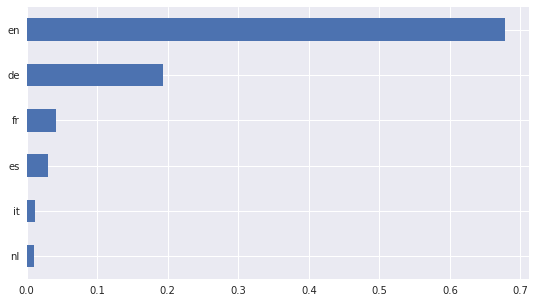

In [22]:
# visualizing the comments' languages a) "quick and dirty"
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

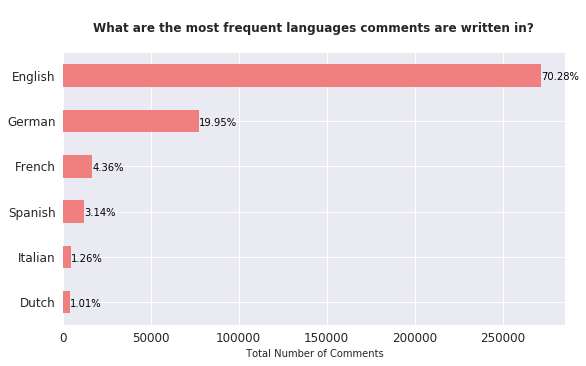

In [23]:
# visualizing the comments' languages b) "slowly and nice"
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y()+.35, 
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [24]:
# splitting the dataframes in language related sub-dataframes
df_eng = df[(df['language']=='en')]
df_de  = df[(df['language']=='de')]
df_fr  = df[(df['language']=='fr')]

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Visualizing the Data with WordClouds
<a id='3. Visualizing the Data with WordClouds'></a>

**Preparing Steps**

In [25]:
# 1. import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string

In [36]:
# 2. wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

**English WordCloud**

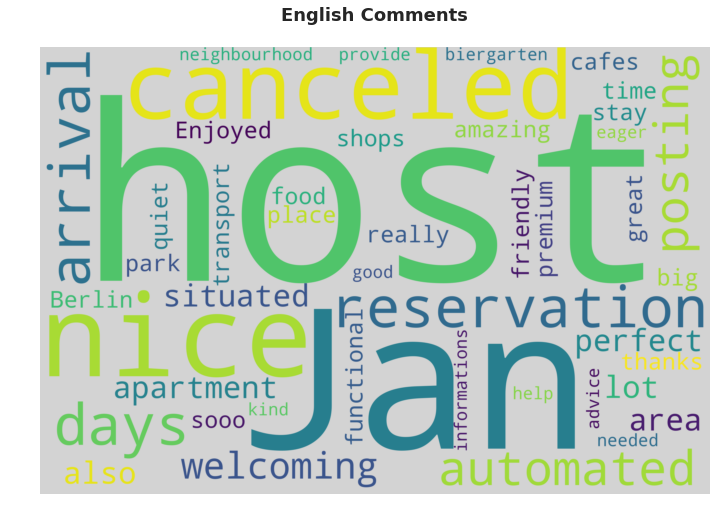

In [37]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

**German WordCloud**

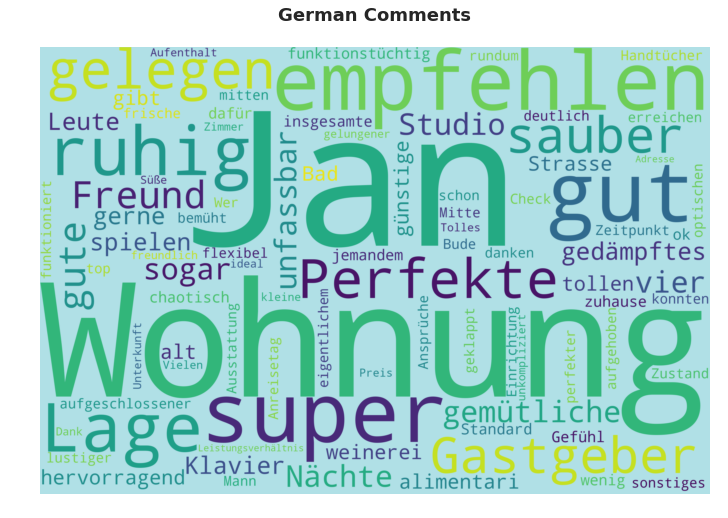

In [39]:
wordcloud = WordCloud(max_font_size=None, max_words=150, background_color="powderblue",
                      width=3000, height=2000,
                      stopwords=stopwords.words('german')).generate(str(df_de.comments.values))

plot_wordcloud(wordcloud, 'German')

**French WordCloud**

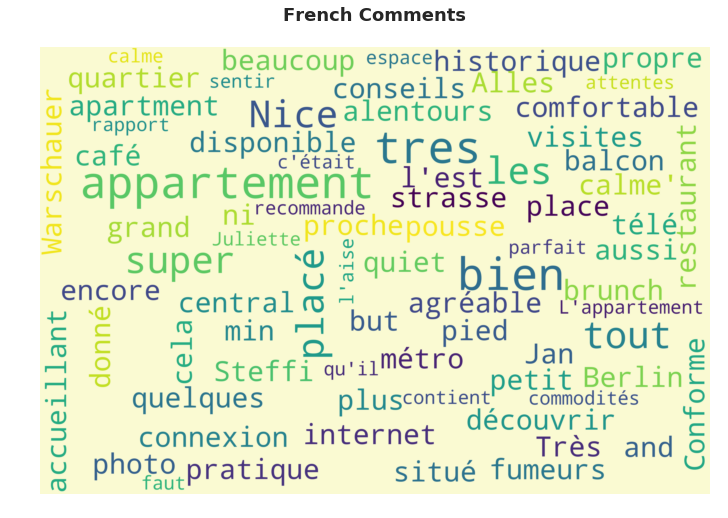

In [40]:
wordcloud = WordCloud(max_font_size=200, max_words=150, background_color="lightgoldenrodyellow",
                      #width=1600, height=800,
                      width=3000, height=2000,
                      stopwords=stopwords.words('french')).generate(str(df_fr.comments.values))

plot_wordcloud(wordcloud, 'French')

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Sentiment Analysis
<a id='4. Sentiment Analysis'></a>

#### 4.1. Get used to VADER package
<a id='4.1. Get used to VADER package'></a>

An excellent and easy-to-read overview of sentiment analysis and the VADER package can be found on Jodie Burchell's <a href='http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html'> blogpost</a>. (I don't want to repeat what she worded so I rather recommend reading her own words.)

In [41]:
# load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [42]:
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

In [43]:
# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

VADER belongs to a type of sentiment analysis that is based on lexicons of sentiment-related words. In this approach, each of the words in the lexicon is rated as to whether it is positive or negative, and in many cases, how positive or negative. Let's play around a bit and get familiar with this package:

In [44]:
print_sentiment_scores("This raspberry cake is good.")

This raspberry cake is good.------------ {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}


VADER produces four sentiment metrics from these word ratings, which you can see above. The first three, positive, neutral and negative, represent the proportion of the text that falls into those categories. As you can see, our example sentence was rated as 42% positive, 58% neutral and 0% negative. 

The final metric, **the compound score**, is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1. In this case, our example sentence has a rating of 0.44, which is pretty neutral.

In [45]:
print_sentiment_scores("This raspberry cake is good.")
print_sentiment_scores("This raspberry cake is GOOD!")
print_sentiment_scores("This raspberry cake is VERY GOOD!!")
print_sentiment_scores("This raspberry cake is really GOOD! But the coffee is dreadful.")

This raspberry cake is good.------------ {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}
This raspberry cake is GOOD!------------ {'neg': 0.0, 'neu': 0.505, 'pos': 0.495, 'compound': 0.6027}
This raspberry cake is VERY GOOD!!------ {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.7386}
This raspberry cake is really GOOD! But the coffee is dreadful. {'neg': 0.18, 'neu': 0.558, 'pos': 0.262, 'compound': 0.3222}


In [46]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [47]:
negative_score("The food is really GOOD! But the service is dreadful.")

0.192

In [48]:
neutral_score("The food is really GOOD! But the service is dreadful.")

0.529

In [49]:
positive_score("The food is really GOOD! But the service is dreadful.")

0.279

In [50]:
compound_score("The food is really GOOD! But the service is dreadful.")

0.3222

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 4.2. Calculating Sentiment Scores
<a id='4.2. Calculating Sentiment Scores'></a>

Okay, the band begins to play: Let's VADER produce all four scores for each of our english comments. As this takes roughly a quarter of an hour, it's a good idea to safe the dataframe.

In [11]:
start = datetime.datetime.now()

df_eng['sentiment_neg'] = df_eng['comments'].apply(negative_score)
df_eng['sentiment_neu'] = df_eng['comments'].apply(neutral_score)
df_eng['sentiment_pos'] = df_eng['comments'].apply(positive_score)
df_eng['sentiment_compound'] = df_eng['comments'].apply(compound_score)

finish = datetime.datetime.now()
elapsed = finish - start
print('Time Elapsed:', elapsed)

Time Elapsed: 0:14:56.784536


In [12]:
# write the dataframe to a csv file in order to avoid 14 minutes runtime
df_eng.to_csv('data/sentimentData/sentiment_df_eng', index=False)

In [51]:
df = pd.read_csv('data/sentimentData/sentiment_df_eng')

In [52]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.505,0.495,0.9703
1,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.0,0.530,0.470,0.7955


Let's investigate the distribution of all scores:

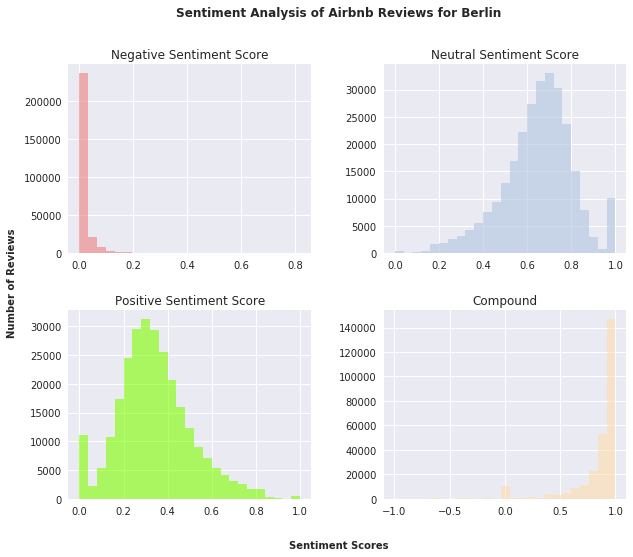

In [54]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and ylabel
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');

Remember what we said earlier: VADER produces four sentiment metrics from these word ratings (...). The first three, positive, neutral and negative, represent the **proportion of the text** that falls into those categories. (...). And the final metric, **the compound score**, is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1.

Let's finally use the describe method and generate descriptive statistics that summarize the central tendency and dispersion of our dataset's compound score:

In [55]:
df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])

count    271836.000000
mean          0.831619
std           0.261954
min          -0.996800
5%            0.051600
10%           0.585900
20%           0.784700
30%           0.862000
40%           0.903200
50%           0.928700
60%           0.946800
70%           0.960800
80%           0.972100
90%           0.982500
max           0.999500
Name: sentiment_compound, dtype: float64

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 4.3. Comparing Negative and Positive Comments
<a id='4.3. Comparing Negative and Positive Comments'></a>

Clearly, the bulk of the reviews is tremendously positive. Wouldn't it be interesting to know what negative and positive comments are all about? Let's have a look:

In [56]:
# full dataframe with negative comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of negative comments
pos_comments = df_pos['comments'].tolist()

In [57]:
# full dataframe with negative comments
df_neg = df.loc[df.sentiment_compound < 0.0]

# only corpus of negative comments
neg_comments = df_neg['comments'].tolist()

Let's compare the length of both positive and negative comments:

In [89]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)

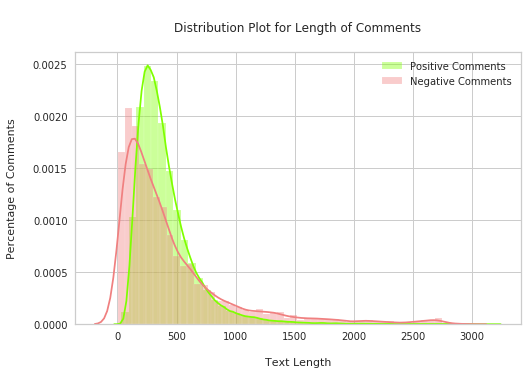

In [93]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments']);
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

Positive comments have their mode for text length more to the right than negative comments, which means most of the positive comments are longer than most of the negative comments. But the tail for negative comments is thicker.

In [59]:
# read some positive comments
pos_comments[10:15]

['The apartment is simple, clean and cozy. The bed is super comfortable and the kitchen is well equipped. Communication with host was simple and clear. The apartment is in a residential and lively area, very close to public transportation. Ideal for two people. We really appreciated the international plug adaptor. Excellent experience. ',
 'Jan was a great host - very communicative and easy to deal with. He provided great recommendations in the area and was extremely friendly!\n\nThe apartment, itself, was in such a nice location, perfect to walk around and explore outside of the more touristy center of the city. It was clean, comfortable, and a great value. \n\nWould definitely recommend to anyone looking to visit Berlin!',
 "Nice, clean, quiet and small apartment in a great location. Basically the listing's description is pretty accurate. \n\nJan was responsive and very helpful, picking up the keys was a breeze. \n\nI would certainly recommend this apartment to visitors looking for s

In [64]:
# read some negative comments
neg_comments[10:15]

['Cosy apartment.  Very fast responds from the host. Furnitures are in good condition. Accessible from Berlin hbf by taking bus no. 245. Only needed to walk quite a long distance to TXL airport bus stop.',
 'Located on main street close to mass transit. Unit is small and noisy.  Unit had several items in need of repair. ',
 'the flat looks messy, walls in the main room are dirty. location is not very good - dont have places to hav a breakfast or to buy coffee. the host give only one pair of keys for three of us and when i asked for additional pair of keys they said it costs 15 euro - so i wasnt very pleased with service. ',
 'first of all I slept on a very poor mattress. (more an old sofa...) second in the guestroom I stayed in there was a problem with draft. the payment was a bit of a hassle too due to the lessors cumbersome communicationstyle. plus the bathroom was incredibly  low-ceilinged and thereby only convinient if you are shorter than 1.70m. even if the flat in total is an imp

Let's quickly check if a scatter plot may reveal some differences in the comments' sentiment with respect to the districts:

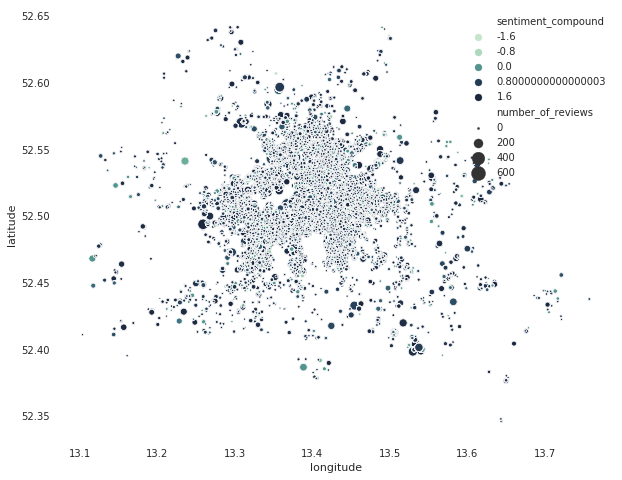

In [65]:
sns.set_style("white")
#sns.despine()

cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x="longitude", y="latitude", size='number_of_reviews', sizes=(5, 200),
                     hue='sentiment_compound', palette=cmap,  data=df)
plt.show();

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 4.4. Investigating Positive Comments
<a id='4.4. Investigating Positive Comments'></a>

**WordCloud**

After reading some of these reviews to get a feeling for what visitors applaud to or complain about, WordClouds are more than welcome to see behind the curtain:

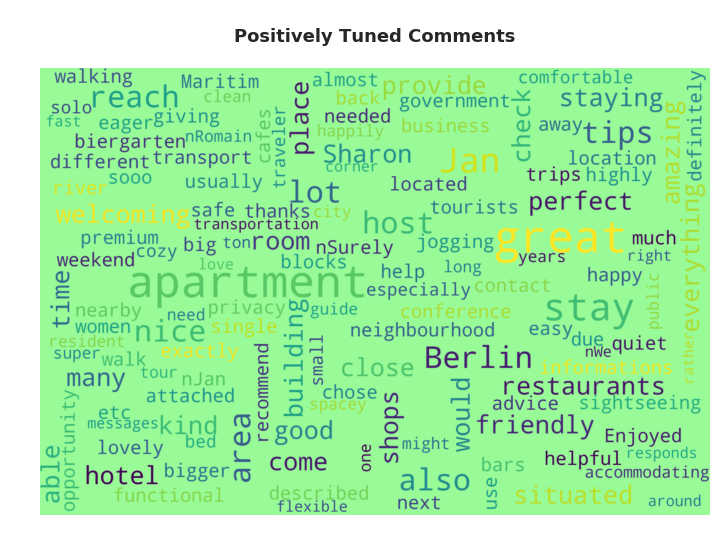

In [73]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="palegreen",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(df_pos.comments.values))

plot_wordcloud(wordcloud, '\nPositively Tuned')

**Frequency Distribution**

Another method for visually exploring text is with frequency distributions. In the context of a text corpus, such a frequency distribution tells us the prevalence of words. Here we use the Yellowbrick library.

In [69]:
# importing libraries
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

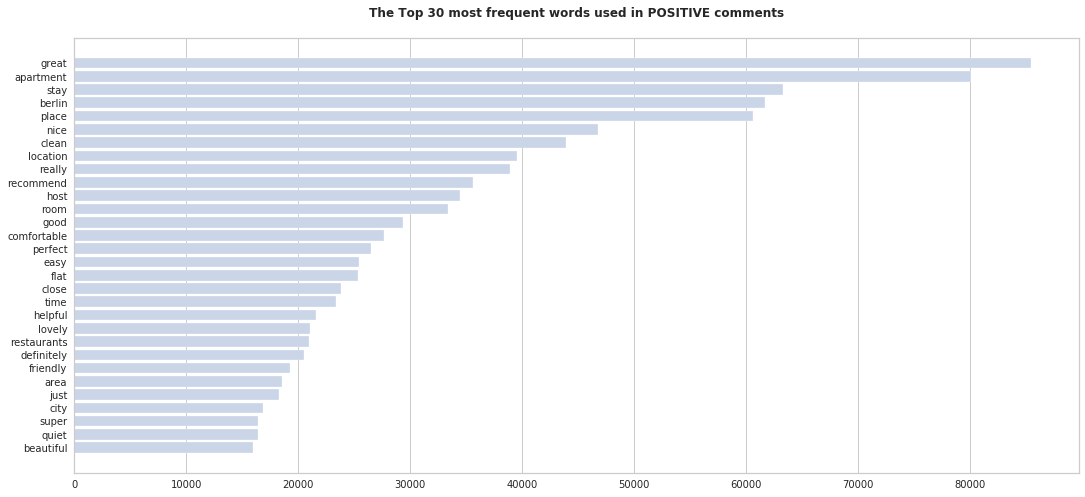

In [70]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(pos_comments)
features = vectorizer.get_feature_names()

# prepare the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

# instantiate and fit the FreqDistVisualizer, plot the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

**Topic Modelling**

Next, we'll explore topic modeling, an unsupervised machine learning technique for abstracting topics from collections of documents or, specifically in our case, for identifying which topic is discussed in a comment. 

Methods for topic modelling, and convenient open source implementations, have evolved significantly over the last decade. In this section, we'll explore a technique called *Latent Dirichlet Allocation (LDA)*, a widely used topic modelling technique.

*1. Cleaning and Preprocessing*

In [76]:
# importing libraries
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [77]:
# prepare preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [78]:
# remove stopwords, punctuations and normalize the corpus
def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(comment).split() for comment in pos_comments]

*2. LDA the Gensim way*

First, we create a Gensim dictionary from the normalized data, then we convert this to a bag-of-words corpus, and save both dictionary and corpus for future use.

In [81]:
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

import pickle
pickle.dump(corpus, open('data/sentimentData/corpus.pkl', 'wb'))
dictionary.save('data/sentimentData/dictionary.gensim')

In [84]:
import gensim

# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model3.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.024*"apartment" + 0.015*"great" + 0.015*"walk" + 0.014*"minute"')
(1, '0.017*"u" + 0.012*"place" + 0.012*"room" + 0.009*"even"')
(2, '0.038*"great" + 0.032*"place" + 0.027*"stay" + 0.022*"apartment"')


- The first topic includes words like *apartment*, *great*, and *walk* along with *minute*. This sounds like a topic related to convenient distances from the accommodation to wherever something interesting was to go to.
- The second topic includes words like *place*, *room*, *even* and mysterious *u* (perhaps u-bahn for the underground?). It seems unclear to me what this is supposed to be about. 
- And the third topic combines words like *great*, *place*, *stay* and *apartment*, which sounds like a cluster related to an overall satisfaction with the home.

In [82]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.049*"nice" + 0.036*"great" + 0.035*"place" + 0.034*"really"')
(1, '0.026*"place" + 0.026*"berlin" + 0.021*"stay" + 0.020*"home"')
(2, '0.081*"u" + 0.025*"apartment" + 0.017*"stay" + 0.016*"gave"')
(3, '0.036*"great" + 0.030*"apartment" + 0.022*"place" + 0.021*"stay"')
(4, '0.011*"kitchen" + 0.011*"bed" + 0.011*"room" + 0.010*"apartment"')


In [83]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model10.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.021*"bed" + 0.020*"kitchen" + 0.019*"room" + 0.016*"bathroom"')
(1, '0.152*"appartment" + 0.028*"sarah" + 0.017*"responding" + 0.015*"la"')
(2, '0.031*"walk" + 0.029*"minute" + 0.024*"station" + 0.021*"apartment"')
(3, '0.034*"flat" + 0.022*"family" + 0.017*"quiet" + 0.016*"restaurant"')
(4, '0.025*"home" + 0.024*"berlin" + 0.022*"place" + 0.018*"best"')
(5, '0.156*"u" + 0.034*"gave" + 0.021*"tip" + 0.018*"made"')
(6, '0.021*"check" + 0.018*"even" + 0.014*"late" + 0.014*"time"')
(7, '0.051*"nice" + 0.038*"place" + 0.036*"really" + 0.033*"room"')
(8, '0.053*"great" + 0.043*"stay" + 0.041*"place" + 0.028*"would"')
(9, '0.056*"great" + 0.037*"apartment" + 0.031*"stay" + 0.028*"place"')


Putting it all together, the WordCloud, the Frequency Distribution and the Topic Modelling, **it is often the following that makes someone rate an apartment positively:**
1. The apartment is clean, the bathroom is clean, the bed is comfortable.
2. The apartment is quiet to get a deep sound sleep.
3. The area is in the middle of everything with short walking distances, good public transport connections and cafes and restaurants around.

Apparently, getting the last two means trying to square the circle... But this is true for tourists all over the world.

Before we move on to the negative comments, let's visualize the LDA model:

*3. Visualizing topics*

The pyLDAvis library is designed to provide a visual interface for interpreting the topics derived from a topic model by extracting information from a fitted LDA topic model.

In [86]:
dictionary = gensim.corpora.Dictionary.load('data/sentimentData/dictionary.gensim')
corpus = pickle.load(open('data/sentimentData/corpus.pkl', 'rb'))

import pyLDAvis.gensim

In [87]:
lda = gensim.models.ldamodel.LdaModel.load('data/sentimentData/model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In short, the interface provides:

- a left panel that depicts a global view of the model (how prevalent each topic is and how topics relate to each other);
- a right panel containing a bar chart – the bars represent the terms that are most useful in interpreting the topic currently selected (what the meaning of each topic is).

On the left, the topics are plotted as circles, whose centers are defined by the computed distance between topics (projected into 2 dimensions). The prevalence of each topic is indicated by the circle’s area. On the right, two juxtaposed bars showing the topic-specific frequency of each term (in red) and the corpus-wide frequency (in blueish gray). When no topic is selected, the right panel displays the top 30 most salient terms for the dataset.

In [94]:
lda = gensim.models.ldamodel.LdaModel.load('data/sentimentData/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 4.5. Investigating Negative Comments
<a id='4.5. Investigating Negative Comments'></a>

**WordCloud**

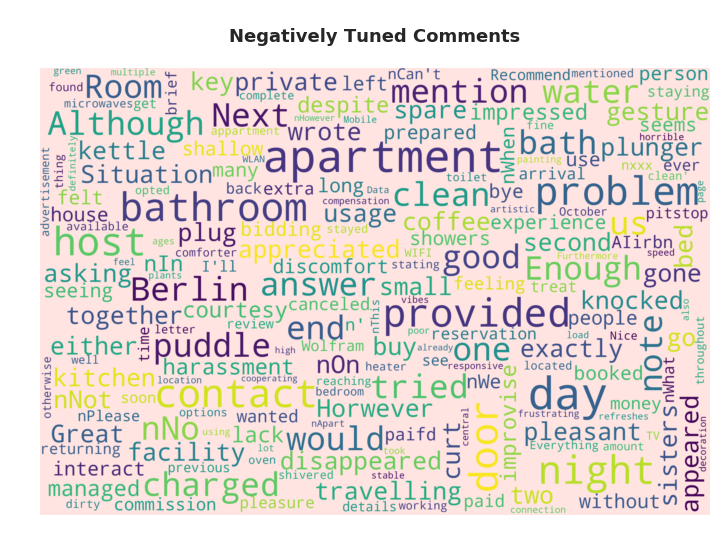

In [74]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="mistyrose",
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_neg.comments.values))

plot_wordcloud(wordcloud, '\nNegatively Tuned')

**Frequency Distribution**

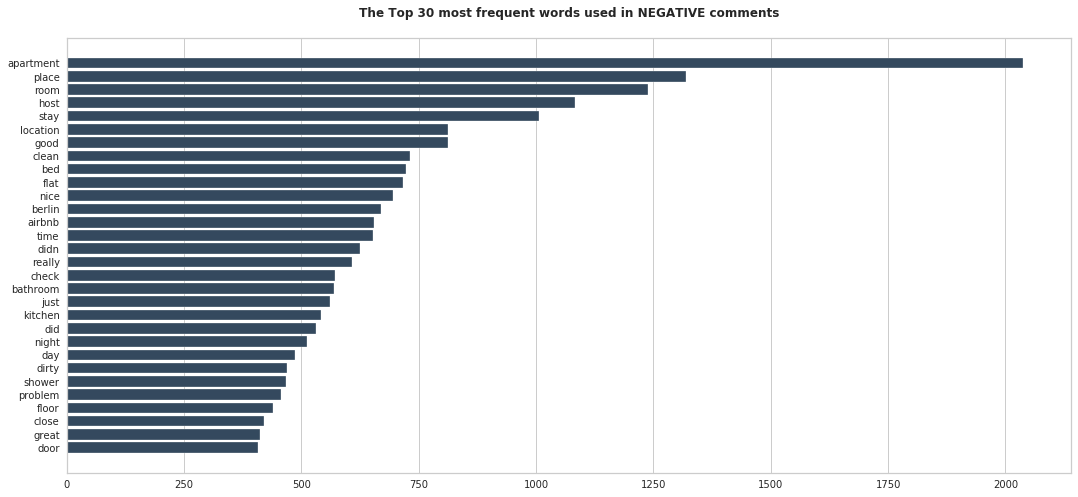

In [75]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(neg_comments)
features = vectorizer.get_feature_names()

# prepare the plot
set_palette('flatui')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

# instantiate and fit the FreqDistVisualizer, plot the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

**Topic Modelling**

*1. Cleaning and Preprocessing*

In [96]:
doc_clean = [clean(comment).split() for comment in neg_comments]

*2. LDA the Gensim way*

In [97]:
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

pickle.dump(corpus, open('data/sentimentData/corpus_neg.pkl', 'wb'))
dictionary.save('data/sentimentData/dictionary_neg.gensim')

In [98]:
# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model3_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.014*"apartment" + 0.011*"place" + 0.010*"close" + 0.010*"problem"')
(1, '0.006*"wifi" + 0.005*"dirty" + 0.005*"room" + 0.005*"parking"')
(2, '0.015*"apartment" + 0.011*"u" + 0.010*"room" + 0.010*"place"')


In [99]:
# now let LDA find 5 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model5_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.017*"war" + 0.012*"und" + 0.012*"die" + 0.010*"e"')
(1, '0.016*"day" + 0.015*"host" + 0.013*"reservation" + 0.011*"stay"')
(2, '0.012*"apartment" + 0.009*"stay" + 0.009*"bed" + 0.006*"flat"')
(3, '0.017*"apartment" + 0.016*"host" + 0.012*"u" + 0.010*"airbnb"')
(4, '0.015*"apartment" + 0.013*"place" + 0.013*"room" + 0.009*"u"')


In [100]:
# and finally 10 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)
ldamodel.save('data/sentimentData/model10_neg.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.032*"host" + 0.017*"day" + 0.012*"airbnb" + 0.012*"arrival"')
(1, '0.018*"u" + 0.012*"pay" + 0.010*"charge" + 0.010*"euro"')
(2, '0.032*"apartment" + 0.012*"key" + 0.011*"place" + 0.010*"u"')
(3, '0.017*"und" + 0.016*"die" + 0.011*"war" + 0.010*"sehr"')
(4, '0.015*"apartment" + 0.012*"room" + 0.011*"u" + 0.011*"place"')
(5, '0.007*"recommended" + 0.006*"toll" + 0.005*"saskia" + 0.005*"would"')
(6, '0.034*"war" + 0.025*"alles" + 0.016*"e" + 0.011*"top"')
(7, '0.030*"dirty" + 0.017*"room" + 0.017*"bathroom" + 0.015*"kitchen"')
(8, '0.026*"apartment" + 0.020*"place" + 0.015*"location" + 0.014*"room"')
(9, '0.012*"flat" + 0.011*"u" + 0.010*"time" + 0.009*"stay"')


Let's again put all visualizations together and summarize **what makes someone rate an apartment negatively:**
1. The apartment and/or bathroom, especially the shower, are dirty.
2. It seems that problems in communicating with the host, e.g. onesided cancellations by the host or to not get hold of him/her when having issues - might be a reason for complaining.
3. The area is too far away from public transport connections or doesn't meet the vistors' expectations in whatsoever aspects.

Before we finish analyzing the negative comments, let's visualize the LDA model:

*3. Visualizing topics*

In [101]:
dictionary = gensim.corpora.Dictionary.load('data/sentimentData/dictionary_neg.gensim')
corpus = pickle.load(open('data/sentimentData/corpus_neg.pkl', 'rb'))

In [102]:
lda = gensim.models.ldamodel.LdaModel.load('data/sentimentData/model5_neg.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [103]:
lda = gensim.models.ldamodel.LdaModel.load('data/sentimentData/model3_neg.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 6. Appendix 
<a id='6. Appendix'></a>

Data
- Inside Airbnb: http://insideairbnb.com/get-the-data.html

WordClouds
- https://vprusso.github.io/blog/2018/natural-language-processing-python-3/
- https://www.datacamp.com/community/tutorials/wordcloud-python

Bar Charts
- http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

YellowBrick Visualization
- http://www.scikit-yb.org/en/latest/index.html

Language Detection
- TextBlob:
    - https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
    - https://github.com/shubhamjn1/TextBlob/blob/master/Textblob.ipynb
    - https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
    - https://textblob.readthedocs.io/en/dev/quickstart.html

- Spacy:
    - https://github.com/nickdavidhaynes/spacy-cld
    - https://spacy.io/usage/models

- Langdetect & LangId:
    - https://pypi.org/project/langdetect/ 
    - https://www.probytes.net/blog/python-language-detection/
    - https://github.com/hb20007/hands-on-nltk-tutorial/blob/master/8-1-The-langdetect-and-langid-Libraries.ipynb

Sentiment Analysis
- Jodie Burchell: http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html
- Jodie Burchell: http://t-redactyl.io/blog/2017/01/how-do-we-feel-about-new-years-resolutions-according-to-sentiment-analysis.html
- Jodie Burchell: https://github.com/t-redactyl/Blog-posts/blob/master/2017-04-15-sentiment-analysis-in-vader-and-twitter-api.ipynb
- http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

- Susan Li: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3
- Sakshi Gupta (in R): https://towardsdatascience.com/uncovering-hidden-trends-in-airbnb-reviews-11eb924f2fec
- Dmytro Iakubovskyi: https://towardsdatascience.com/digging-into-airbnb-data-reviews-sentiments-superhosts-and-prices-prediction-part1-6c80ccb26c6a
- Dmytro Iakubovskyi: https://github.com/Dima806/Airbnb_project/blob/master/airbnb_final_analysis_v3.ipynb
- Maurizio Santamicone: https://medium.com/@mauriziosantamicone/seattle-confidential-unpacking-airbnb-reviews-with-sentiment-d421c15d8b8f
- Zhenyu: https://www.kaggle.com/zhenyufan/nlp-for-yelp-reviews/notebook?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019

Topic Modeling / LDA
- Analytics Vidhya: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
- Susan Li: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- https://radimrehurek.com/gensim/models/ldamodel.html
- https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/

Diverse
- https://data-viz-for-fun.com/2018/08/airbnb-data-viz/